# Тестовое задание

Ссылка на задание
https://drive.google.com/file/d/1RZTunsd-0MHgIBklBx9Xj-ueK4lBfQVd/view
    
В качестве тестового задания предлагается проблема поиска шахматной доски. Вам дается два набора данных (xtrain, ytrain) и xtest.
Формат данных – массив NumPy. Требуется построить модель одного на Ваш выбор алгоритма машинного обучения, обучить на xtrain и предсказать ytest для xtest.

Ссылка для скачивания данных

https://yadi.sk/d/Yv86Kan3BWoEnQ
    
Пример видео с шахматной партией со смартфона

https://yadi.sk/i/y1Lp_oILRiEUgQ

# Обучение модели

In [2]:
# !pip install timm
# !pip install albumentations

Для контроля проведения экспериментов использовалась платформа Weights&Biases.

Результаты доступны по ссылке https://wandb.ai/olgatrofimova96/chess/reports/---VmlldzoxMDczNDU0?accessToken=u1u2e18k835phibjulcoaqoy2o7z6uonn4z6dt7s3xypgpnvcvcbdmxno9zuntmn.

In [ ]:
# !pip install wandb

In [ ]:
import wandb
wandb.login()

Скачивание и распаковка данных с Яндекс.Диск, может занять несколько минут.

In [3]:
import requests
from urllib.parse import urlencode
import os
import zipfile

def load_data():
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://yadi.sk/d/Yv86Kan3BWoEnQ'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)

    with open('chess_data.zip', 'wb') as f:
        f.write(download_response.content)

    with zipfile.ZipFile('chess_data.zip', 'r') as zip_obj:
        zip_obj.extractall()

# load_data()

In [4]:
import timm
import PIL
import albumentations as A

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import cv2
import random

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(24)

Выгрузим набор данных и посмотрим на их структуру.

In [73]:
xtrain = np.load('xtrain.npy')
ytrain = np.load('ytrain.npy')
xtest = np.load('xtest.npy')

print('Train data shape: ', xtrain.shape)
print('Train labels shape: ', ytrain.shape)
print('Test data shape: ', xtest.shape)

Train data shape:  (15137, 256, 256, 1)
Train labels shape:  (15137, 8)
Test data shape:  (5, 256, 256, 1)


Все входные изображения черно-белые (1 канал) и имеют размер 256х256.

In [7]:
PIC_SIZE = xtrain.shape[1]

Функция show_board для визуализации входных данных написана таким образом, чтобы выводить 5 примеров изображений, переданных ей на вход, начиная с n-го.

Флаг is_tensor предусмотрен для корректного отображения фото в формате тензоров, т.к. позиция номера канала отличается для массивов и тензоров.

In [8]:
def show_board(imgs, coords, n=0, is_tensor=False): 
    f, axes = plt.subplots(1, 5, figsize=(20, 10))
    for i, ax in enumerate(axes):
        if not is_tensor:
            img = imgs[n + i, :, :, 0]
        else:
            img = imgs[n + i, 0, :, :]
        
        axes[i].imshow(img, cmap='gray')
        for p in range(4):
            x, y = coords[n + i][2 * p] * PIC_SIZE, coords[n + i][2 * p + 1] * PIC_SIZE
            axes[i].scatter(x, y, s=50, marker='o')
    return f

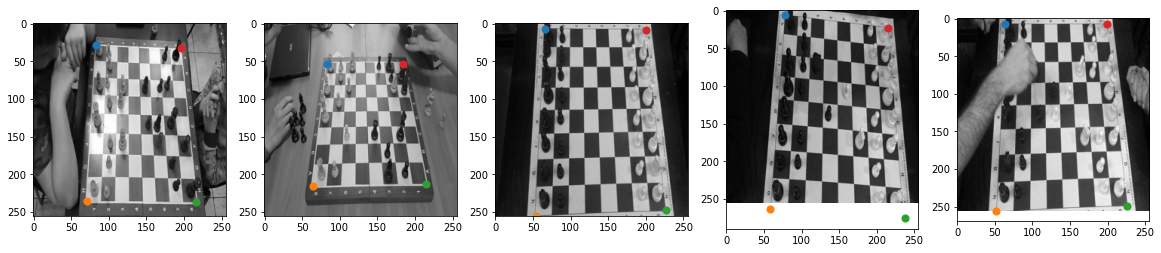

In [9]:
show_board(xtrain, ytrain, 8);

Для использования аугментаций в дальшейшем удобно привести координаты точек к формату keypoints - 4 пары координат:

`keypoints = [(x_0, y_0),
              (x_1, y_1),
              (x_2, y_2),
              (x_3, y_3)
]`

In [10]:
def make_keypoints(y):
    return [(y[2 * i] * PIC_SIZE, y[2 * i + 1] * PIC_SIZE) for i in range(4)]

ytrain_kp = [make_keypoints(crds) for crds in ytrain]

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(xtrain, ytrain_kp, test_size=0.3, random_state=24, shuffle=True)

Чтобы модель лучше училась, применим трансформации к изображениям в обучающей выборке.

In [47]:
a_transform = A.Compose([
    A.Cutout(num_holes=2, max_h_size=80, max_w_size=80),
    A.Perspective(scale=[0.01, 0.07]),
    A.RandomRotate90(),
    A.Flip(),
    A.Blur()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

Координаты точек в выходном векторе имеют следующий порядок:

* х_left_up, y_left_up,
* x_left_down, y_left_down,
* x_right_down, y_right_down,
* x_right_up, y_right_up.

Он может изменяться вследствие применения аугментаций (отражений, поворотов). Важно, чтобы предсказания модели сохраняли указанный порядок, для этого написана функция calc_order, определяющая для каждой пары (x, y) входного массива keypoints к какой четверти изображения они относятся.

In [48]:
def calc_order(kps):
    x_list, y_list = list(zip(*kps))
    mid_x = min(x_list) + 0.5 * (max(x_list) - min(x_list))
    mid_y = min(y_list) + 0.5 * (max(y_list) - min(y_list))
            
    order = []
    for x, y in kps:
        if x < mid_x and y < mid_y:
            order.append(0)
        elif x < mid_x and y > mid_y:
            order.append(1)
        elif x > mid_x and y > mid_y:
            order.append(2)
        elif x > mid_x and y < mid_y:
            order.append(3)
            
    return order

Убедимся, что в исходных данных все координаты имеют один порядок:

In [49]:
for i in range(len(xtrain)):
    y = make_keypoints(ytrain[i])
    if calc_order(y) != [0, 1, 2, 3]:
        print('Wrong order for image number', i)
        show_board(xtrain[i], ytrain[i] / PIC_SIZE, n=i, is_tensor=True)

In [50]:
class CustomImageDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.pics = X
        self.keys = y
        self.transform = transform

    def __len__(self):
        return len(self.pics)

    def __getitem__(self, idx):  
        img = self.pics[idx]
        
        if self.keys is not None:
            if self.transform is not None:
                transformed = self.transform(image=img, keypoints=self.keys[idx])
                img = transformed['image']
                keypoints = transformed['keypoints']
            else:                
                keypoints = self.keys[idx]
                
            # re-ordering keypoints
            ordered = np.zeros((4, 2), dtype=float)
            curr_order = calc_order(keypoints)
            ordered[curr_order] = np.array(keypoints)

            keypoints_lst = ordered.flatten()
            
            img = np.transpose(img, (2, 0, 1)).astype(np.float32)        
            return torch.tensor(img, dtype=torch.float), torch.tensor(keypoints_lst, dtype=torch.float)
        else:
            img = np.transpose(img, (2, 0, 1)).astype(np.float32)  
            return torch.tensor(img, dtype=torch.float)

In [51]:
train_data = CustomImageDataset(X_train, y_train, a_transform)
valid_data = CustomImageDataset(X_valid, y_valid)

In [52]:
batch_size = 40
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

Убедимся, что после применения аугментаций все точки выведены в правильном порядке.

In [53]:
for b in range(len(train_dataloader)):
    X_batch, y_batch = next(iter(train_dataloader))
    y = [make_keypoints(y_batch[j]) for j in range(len(y_batch))]
    for i in range(len(y)):
        if calc_order(y[i]) != [0, 1, 2, 3]:
            print('Wrong order')
            show_board(X_batch, y_batch / PIC_SIZE, n=i, is_tensor=True)

Посмотрим как выглядят изображения после применения аугментаций.

In [54]:
X_batch, y_batch = next(iter(train_dataloader));

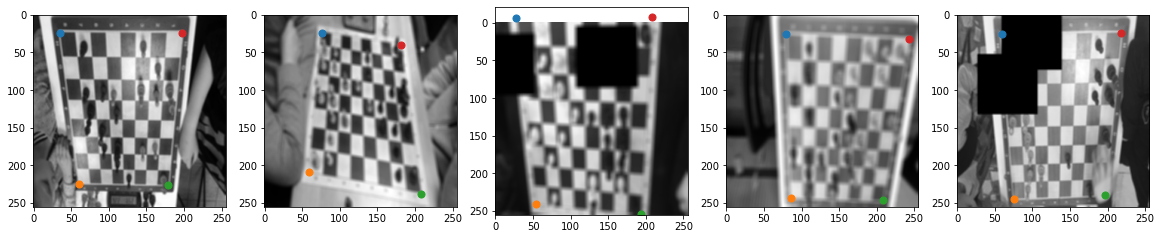

In [55]:
show_board(X_batch, y_batch / PIC_SIZE, n=0, is_tensor=True);

Для тренировки используетя ResNet с pretrained весами.
На вход модели поступают черно-белые изображения, поэтому in_chans указан равным 1. Количество выходов соответствует 8 координатам, которые необходимо предсказать.

In [56]:
model = timm.create_model("resnet34", num_classes=8, in_chans=1, pretrained=True)

В сети ResNet после свёрток в конце применяется average pooling. Он потенциально способен помешать корректному предсказанию точных координат, т.к. в результате усреднения можно потерять информацию о положении фичей относительно друг друга. Несколько экспериментов проведено без пуллинга.

In [57]:
model.global_pool = torch.nn.Flatten()
model.fc = nn.Sequential(
          nn.Linear(in_features=32768, out_features=512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=8)
        )

В качестве функции потерь выбрана L1Loss (MAE), вычисляющая расстояние между предсказанной и искомой коорданатами. Для сравнения также проводились эксперименты с MSE функцией, принципиальных отличий в результате нет. 

Также в модель передается scheduler, который будет уменьшать learning rate каждые 5 эпох обучения.

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [61]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    run = wandb.init(project='chess')
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()                
            else:
                dataloader = valid_dataloader
                model.eval()

            epoch_loss = 0.0

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()                        

                epoch_loss += loss_value.item()
                                
            avg_epoch_loss = epoch_loss / len(dataloader)
            
            wandb.log({f"{phase}_loss": avg_epoch_loss})
            print('{} Loss: {:.4f}'.format(phase, avg_epoch_loss), flush=True)
    return model

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=20);

Сохранение обученной модели.

In [64]:
# torch.save(model, 'model.pth')

Загрузка модели.

In [26]:
# model = torch.load('model.pth')

Подсчитаем предсказания для тестовых данных.

In [65]:
test_data = CustomImageDataset(xtest)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [66]:
def test_model(model, test_dataloader):
    test_predictions = []
    model.eval()

    for inputs in test_dataloader:
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(preds.cpu())

    test_predictions = np.concatenate(test_predictions)
    return test_predictions / PIC_SIZE

In [67]:
test_predictions = test_model(model, test_dataloader)

Чтобы убедиться в работоспособности модели, можно визуализировать предсказания тестовых данных.

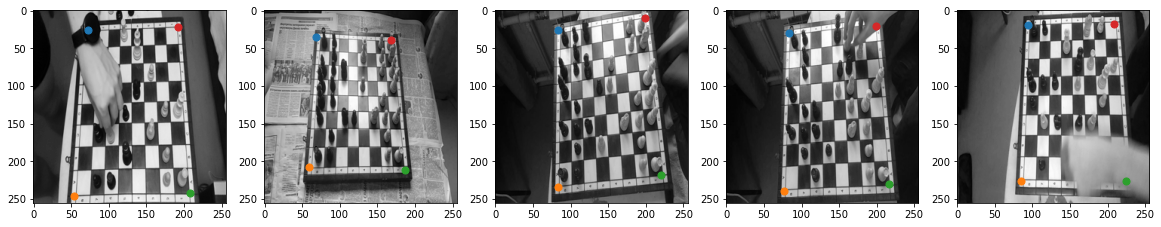

In [68]:
res = show_board(xtest, test_predictions)

Логгирование полученных изображений.

In [72]:
wandb.log({"examples": wandb.Image(res)})
wandb.finish()

Error: You must call wandb.init() before wandb.log()

# Локализация на видео

Используем полученную модель для распознавания углов шахматной доски на видео. Для каждого кадра из видео будем находить и отрисовывать точки. 

Функции mark_video необходимо передать путь к исходному видео, путь к выходному(обработанному) видео, модель для предсказания.

In [70]:
def mark_video(in_file_path, out_file_path, model, b_size=256):
    v = cv2.VideoCapture(in_file_path)
    fps = int(v.get(cv2.CAP_PROP_FPS))
    width = int(v.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(v.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_file_path, fourcc, fps, (width,  height))
    
    exit_flag = True
    b_size = b_size

    while exit_flag:
        batch_inputs = []
        vid_batch = []
        for _ in range(b_size):
            ret, frame = v.read()
            if not ret:
                exit_flag = False
                break    
            # original frames
            batch_inputs.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # transformed frames to make predictions
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(gray, (PIC_SIZE, PIC_SIZE))
            img_ext = np.expand_dims(img, axis=2)
            vid_batch.append(img_ext)      

        vid_data = CustomImageDataset(vid_batch)
        vid_dataloader = DataLoader(vid_data, batch_size=b_size, shuffle=False)
        vid_preds = test_model(model, vid_dataloader)

        if exit_flag:
            for b in range(b_size):
                output = batch_inputs[b].copy()
                for i in range(4):
                    x, y = int(vid_preds[b][2 * i] * width), int(vid_preds[b][2 * i + 1] * height)
                    output = cv2.circle(output, (x, y), 5, (128, 0, 0), 10)
                out.write(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

    out.release()

Процесс предсказания и отрисовки точек может занять около 5 минут.

In [71]:
mark_video('part6.mp4', 'output.mp4', model)